# **Import**

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

!pip install catboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

!pip install optuna
import optuna

from sklearn.metrics import mean_absolute_error, mean_squared_error

# **Data Load**

In [ ]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [ ]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD001.csv')

In [ ]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

In [ ]:
test_df = pd.read_csv('./test_FD001.csv')
rul_df = pd.read_csv('./RUL_FD001.csv')

In [ ]:
results = {}

using_sensors = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]

# **Hyperparameter Tuning**

In [ ]:
def make_cum_stat(df, is_train=True):
    tmp_df = df.copy()
    stat_df = []

    for unit in tmp_df['unit_number'].unique():
        unit_data = tmp_df[tmp_df['unit_number'] == unit]
        for t in range(2, len(unit_data) + 1):  # 최소 2개 시점부터
            sub_data = unit_data.iloc[:t]  # 1~t
            features = {'unit_number': unit, 'time_cycles': sub_data['time_cycles'].iloc[-1]}

            for sensor in using_sensors:
                features[f'{sensor}_mean'] = sub_data[sensor].mean()
                features[f'{sensor}_std'] = sub_data[sensor].std()
                features[f'{sensor}_min'] = sub_data[sensor].min()
                features[f'{sensor}_max'] = sub_data[sensor].max()
                features[f'{sensor}_last'] = sub_data[sensor].iloc[-1]
                features[f'{sensor}_median'] = sub_data[sensor].median()
                # trend는 최소 2개 이상 시점에서만 계산 가능
                features[f'{sensor}_trend'] = np.polyfit(sub_data['time_cycles'], sub_data[sensor], 1)[0]

            if is_train:
                features['RUL'] = sub_data['RUL'].iloc[-1]

            stat_df.append(features)

    return pd.DataFrame(stat_df)

In [ ]:
cum_stat_train_df = make_cum_stat(train_df, is_train=True)
cum_stat_test_df = make_cum_stat(test_df, is_train=False)

## **Bagging Regression**
- Data: Cumulative Stat
- Scaler: None
- RUL Clipping: False

In [ ]:
train_x = cum_stat_train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y = cum_stat_train_df['RUL'].copy()
train_y.loc[train_y > 125] = 125
train_y = train_y.values.ravel()

def objective_bg(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    dt_max_depth = trial.suggest_int('dt_max_depth', 3, 10)
    dt_min_samples_leaf = trial.suggest_int('dt_min_samples_leaf', 1, 5)

    base_estimator = DecisionTreeRegressor(max_depth=dt_max_depth, min_samples_leaf=dt_min_samples_leaf, random_state=42)
    model = BaggingRegressor(estimator=base_estimator,
                             n_estimators=n_estimators,
                             max_samples=max_samples,
                             max_features=max_features,
                             random_state=42,
                             n_jobs=-1)

    score = -np.mean(cross_val_score(model, train_x, train_y, cv=3, scoring='neg_mean_absolute_error'))
    return score

study_bg = optuna.create_study(direction='minimize')
study_bg.optimize(objective_bg, n_trials=30)

In [ ]:
print("Best Bagging params:", study_bg.best_params)

Best Bagging params: {'n_estimators': 98, 'max_samples': 0.8116796381682547, 'max_features': 0.8895004164062775, 'dt_max_depth': 10, 'dt_min_samples_leaf': 4}


In [ ]:
best_bg_params = study_bg.best_params
base_dt = DecisionTreeRegressor(
    max_depth=best_bg_params['dt_max_depth'],
    min_samples_leaf=best_bg_params['dt_min_samples_leaf']
)
bg_model = BaggingRegressor(
    estimator=base_dt,
    n_estimators=best_bg_params['n_estimators'],
    max_samples=best_bg_params['max_samples'],
    max_features=best_bg_params['max_features'],
    random_state=42,
    n_jobs=-1
)
bg_model.fit(train_x, train_y)

test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number').copy()
pred_bg = bg_model.predict(test_x)
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_bg = mean_absolute_error(true, pred_bg)
rmse_bg = np.sqrt(mean_squared_error(true, pred_bg))
results['Bagging'] = {'MAE': mae_bg, 'RMSE': rmse_bg}

In [ ]:
print(f'MAE: {mae_bg}, RMSE: {rmse_bg}')

MAE: 7.7826991679000574, RMSE: 10.925302962008036


## **RandomForest Regression**

In [ ]:
train_x = cum_stat_train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y = cum_stat_train_df['RUL'].copy()
train_y.loc[train_y > 125] = 125
train_y = train_y.values.ravel()

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    score = -np.mean(cross_val_score(model, train_x, train_y, cv=3, scoring='neg_mean_absolute_error'))
    return score

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=30)

In [ ]:
print("Best RF params:", study_rf.best_params)

Best RF params: {'n_estimators': 478, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.7370473222874097}


In [ ]:
best_rf_params = study_rf.best_params
rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    random_state=42,
    n_jobs=-1
)
rf_model.fit(train_x, train_y)

test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_rf = rf_model.predict(test_x)
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_rf = mean_absolute_error(true, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(true, pred_rf))
results['RandomForest'] = {'MAE': mae_rf, 'RMSE': rmse_rf}
print(f'MAE: {mae_rf}, RMSE: {rmse_rf}')

MAE: 7.224340254189023, RMSE: 10.543476917153876


## **LightGBM**

In [ ]:
train_x = cum_stat_train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y = cum_stat_train_df['RUL'].copy()
train_y.loc[train_y > 125] = 125
train_y = train_y.values.ravel()

def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMRegressor(**params)
    score = -np.mean(cross_val_score(model, train_x, train_y, cv=3, scoring='neg_mean_absolute_error'))
    return score

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

In [ ]:
print("Best LGBM params:", study_lgb.best_params)

Best LGBM params: {'num_leaves': 67, 'max_depth': 18, 'learning_rate': 0.030452837472019594, 'n_estimators': 444, 'subsample': 0.609884480784948, 'colsample_bytree': 0.9273679647409769}


In [ ]:
best_lgb_params = study_lgb.best_params
lgb_model = LGBMRegressor(**best_lgb_params)
lgb_model.fit(train_x, train_y)

test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_lgb = lgb_model.predict(test_x)
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_lgb = mean_absolute_error(true, pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(true, pred_lgb))
results['LightGBM'] = {'MAE': mae_lgb, 'RMSE': rmse_lgb}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20902
[LightGBM] [Info] Number of data points in the train set: 20531, number of used features: 99
[LightGBM] [Info] Start training from score 86.643369


In [ ]:
print(f'MAE: {mae_lgb}, RMSE: {rmse_lgb}')

MAE: 7.366930381388939, RMSE: 10.700133093672058


## **CatBoost Regression**

In [ ]:
train_x = cum_stat_train_df.drop(columns=['unit_number', 'RUL']).copy()
train_y = cum_stat_train_df['RUL'].copy()
train_y.loc[train_y > 125] = 125
train_y = train_y.values.ravel()

def objective_cat(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'verbose': 0,
        'random_state': 42
    }
    model = CatBoostRegressor(**params)
    score = -np.mean(cross_val_score(model, train_x, train_y, cv=3, scoring='neg_mean_absolute_error'))
    return score

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=30)

In [ ]:
print("Best CatBoost params:", study_cat.best_params)

Best CatBoost params: {'depth': 8, 'learning_rate': 0.019359487526314927, 'iterations': 1148, 'l2_leaf_reg': 5.682499598909098, 'bagging_temperature': 0.26073442279374637}


In [ ]:
best_cat_params = study_cat.best_params
cat_model = CatBoostRegressor(**best_cat_params)
cat_model.fit(train_x, train_y)

test_x = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_cat = cat_model.predict(test_x)
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_cat = mean_absolute_error(true, pred_cat)
rmse_cat = np.sqrt(mean_squared_error(true, pred_cat))
results['CatBoost'] = {'MAE': mae_cat, 'RMSE': rmse_cat}

In [ ]:
print(f'MAE: {mae_cat}, RMSE: {rmse_cat}')

MAE: 7.711347637159688, RMSE: 10.682875331015653


## **LSTM**

In [ ]:
using_stats = [col for col in cum_stat_train_df.columns if col.startswith('s')]

def make_cum_train_sequence_data(df, seq_len):
    x, y = [], []

    for unit in df['unit_number'].unique():
        unit_df = df[df['unit_number'] == unit]
        sensor_values = unit_df[using_stats].values
        rul_values = unit_df['RUL'].values

        for i in range(len(unit_df) - seq_len + 1):
            x.append(sensor_values[i:i + seq_len])
            y.append(rul_values[i + seq_len - 1])

    return np.array(x), np.array(y)

def make_cum_test_sequence_data(df, seq_len):
    x = []
    unit_list = df['unit_number'].unique()

    for unit in unit_list:
        unit_df = df[df['unit_number'] == unit]
        values = unit_df[using_stats].values

        if len(unit_df) >= seq_len:
            x.append(values[-seq_len:])
        else:
            pad = np.repeat(values[-1:], seq_len - len(unit_df), axis=0)
            x.append(np.vstack([pad, values]))

    return np.array(x)

In [ ]:
def build_lstm_model(seq_len, n_features, hidden_dim, dropout):
    model = Sequential([
        LSTM(hidden_dim, input_shape=(seq_len, n_features)),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

In [ ]:
scaled_train_df = cum_stat_train_df.copy()
scaled_test_df = cum_stat_test_df.copy()

scaled_train_df.loc[scaled_train_df['RUL'] > 125, 'RUL'] = 125

x_train_df = scaled_train_df[using_stats]
x_test_df = scaled_test_df[using_stats]

scaler = RobustScaler()
scaler.fit(x_train_df)

scaled_train_df[using_stats] = scaler.transform(x_train_df)
scaled_test_df[using_stats] = scaler.transform(x_test_df)

train_x, train_y = make_cum_train_sequence_data(scaled_train_df, 50)
test_x = make_cum_test_sequence_data(scaled_test_df, 50)

def objective_lstm(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 64)

    model = build_lstm_model(50, n_features=train_x.shape[2], hidden_dim=hidden_dim, dropout=dropout)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

    history = model.fit(train_x, train_y, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0)
    val_mae = min(history.history['val_mae'])
    return val_mae

study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=30)

In [ ]:
print("Best LSTM params:", study_lstm.best_params)

Best LSTM params: {'hidden_dim': 118, 'dropout': 0.3008169436103714, 'lr': 0.0011405817248307279, 'batch_size': 58}


In [ ]:
best_lstm_params = study_lstm.best_params
hidden_dim = best_lstm_params['hidden_dim']
dropout = best_lstm_params['dropout']
lr = best_lstm_params['lr']
batch_size = best_lstm_params['batch_size']

lstm_model = build_lstm_model(50, n_features=train_x.shape[2], hidden_dim=hidden_dim, dropout=dropout)
lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
lstm_model.fit(train_x, train_y, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0)

pred_lstm = lstm_model.predict(test_x).flatten()
true = rul_df['RUL'].copy()
true.loc[true > 125] = 125
true = true.values.ravel()

mae_lstm = mean_absolute_error(true, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(true, pred_lstm))
results['LSTM'] = {'MAE': mae_lstm, 'RMSE': rmse_lstm}

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
print(f'MAE: {mae_lstm}, RMSE: {rmse_lstm}')

MAE: 8.042402267456055, RMSE: 12.128666588815781


## **Result**

In [ ]:
results_df = pd.DataFrame(results).T
results_df['RMSE-MAE'] = results_df['RMSE'] - results_df['MAE']
results_df

,MAE,RMSE,RMSE-MAE
Bagging,7.782699,10.925303,3.142604
RandomForest,7.224340,10.543477,3.319137
LightGBM,7.366930,10.700133,3.333203
CatBoost,7.711348,10.682875,2.971528
LSTM,8.042402,12.128667,4.086264


# **Error Correlation**

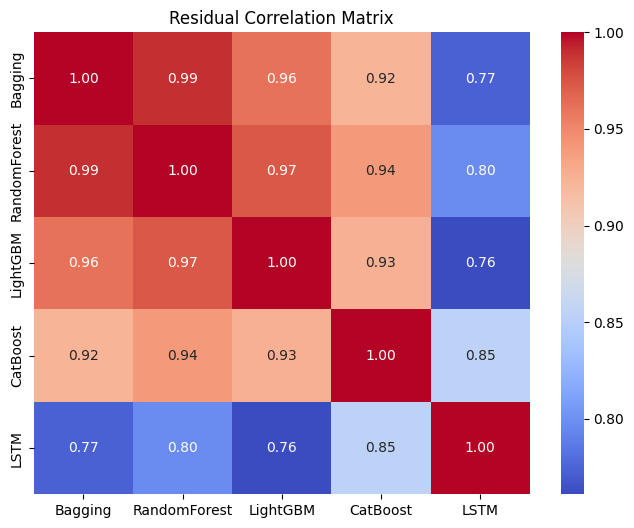

In [ ]:
# 오차 벡터 생성
true = rul_df['RUL'].values.ravel()
errors = pd.DataFrame({
    'Bagging': true - pred_bg,
    'RandomForest': true - pred_rf,
    'LightGBM': true - pred_lgb,
    'CatBoost': true - pred_cat,
    'LSTM': true - pred_lstm
})

# 상관관계 계산
corr_matrix = errors.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Residual Correlation Matrix")
plt.show()

# **Ensemble**

In [ ]:
ensemble_results = {}

def make_cum_val_sequence_data(df, seq_len):
    x, y = [], []
    unit_list = df['unit_number'].unique()

    for unit in df['unit_number'].unique():
        unit_df = df[df['unit_number'] == unit]
        sensor_values = unit_df[using_stats].values
        rul_values = unit_df['RUL'].values

        x.append(sensor_values[-seq_len:])
        y.append(rul_values[-1])

    return np.array(x), np.array(y)

In [ ]:
scaled_train_df = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 80].copy()
scaled_val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 80].copy()
scaled_train_df.loc[scaled_train_df['RUL'] > 125, 'RUL'] = 125
scaled_val_df.loc[scaled_val_df['RUL'] > 125, 'RUL'] = 125
scaled_test_df = cum_stat_test_df.copy()

x_train_df = scaled_train_df[using_stats]
x_val_df = scaled_val_df[using_stats]
x_test_df = scaled_test_df[using_stats]

scaler = RobustScaler()
scaler.fit(x_train_df)
scaled_train_df[using_stats] = scaler.transform(x_train_df)
scaled_val_df[using_stats] = scaler.transform(x_val_df)
scaled_test_df[using_stats] = scaler.transform(x_test_df)

train_x_lstm, train_y_lstm = make_cum_train_sequence_data(scaled_train_df, 50)
val_x_lstm, val_y_lstm = make_cum_val_sequence_data(scaled_val_df, 50)
test_x_lstm = make_cum_test_sequence_data(scaled_test_df, 50)

best_lstm_params = study_lstm.best_params
hidden_dim = best_lstm_params['hidden_dim']
dropout = best_lstm_params['dropout']
lr = best_lstm_params['lr']
batch_size = best_lstm_params['batch_size']

lstm_model = build_lstm_model(50, n_features=train_x_lstm.shape[2], hidden_dim=hidden_dim, dropout=dropout)
lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
lstm_model.fit(train_x_lstm, train_y_lstm, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0)

pred_lstm_val = lstm_model.predict(val_x_lstm).flatten()
pred_lstm_test = lstm_model.predict(test_x_lstm).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


## **Bagging + LSTM**

In [ ]:
train_x_bg = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 80].drop(columns=['unit_number', 'RUL']).copy()
train_y_bg = cum_stat_train_df.loc[cum_stat_train_df['unit_number'] <= 80, 'RUL'].copy()
train_y_bg.loc[train_y_bg > 125] = 125
train_y_bg = train_y_bg.values.ravel()

val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 80].copy()
val_x_bg = val_df.groupby('unit_number').tail(1).drop(columns=['unit_number', 'RUL']).copy()
val_y_bg = val_df.groupby('unit_number')['RUL'].tail(1).copy()
val_y_bg.loc[val_y_bg > 125] = 125
val_y_bg = val_y_bg.values.ravel()

best_bg_params = study_bg.best_params
base_dt = DecisionTreeRegressor(
    max_depth=best_bg_params['dt_max_depth'],
    min_samples_leaf=best_bg_params['dt_min_samples_leaf']
)
bg_model = BaggingRegressor(
    estimator=base_dt,
    n_estimators=best_bg_params['n_estimators'],
    max_samples=best_bg_params['max_samples'],
    max_features=best_bg_params['max_features'],
    random_state=42,
    n_jobs=-1
)
bg_model.fit(train_x_bg, train_y_bg)

pred_bg_val = bg_model.predict(val_x_bg)

test_x_bg = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_bg_test = bg_model.predict(test_x_bg)

In [ ]:
def objective(trial):
    w_bg = trial.suggest_float("w_bg", 0.0, 1.0)
    w_lstm = 1.0 - w_bg

    pred_ensemble = w_bg * pred_bg_val + w_lstm * pred_lstm_val
    rmse = mean_squared_error(val_y_bg, pred_ensemble)**0.5

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_weights = study.best_params

In [ ]:
print("Best weights:", best_weights)

Best weights: {'w_bg': 0.19363884665832698}


In [ ]:
best_w = study.best_params['w_bg']
pred_ensemble_test = best_w * pred_bg_test + (1 - best_w) * pred_lstm_test
test_y_true = rul_df['RUL'].values.ravel()
mae_bg = mean_absolute_error(test_y_true, pred_ensemble_test)
rmse_bg = mean_squared_error(test_y_true, pred_ensemble_test)**0.5

ensemble_results['Bagging + LSTM'] = {'MAE': mae_bg, 'RMSE': rmse_bg}
print(f"Ensemble weight (bg): {best_w:.3f}")
print(f"Test MAE: {mae_bg:.3f}, RMSE: {rmse_bg:.3f}")

Ensemble weight (bg): 0.194
Test MAE: 9.427, RMSE: 13.275


## **RadomForest + LSTM**

In [ ]:
train_x_rf = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 80].drop(columns=['unit_number', 'RUL']).copy()
train_y_rf = cum_stat_train_df.loc[cum_stat_train_df['unit_number'] <= 80, 'RUL'].copy()
train_y_rf.loc[train_y_rf > 125] = 125
train_y_rf = train_y_rf.values.ravel()

val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 80].copy()
val_x_rf = val_df.groupby('unit_number').tail(1).drop(columns=['unit_number', 'RUL']).copy()
val_y_rf = val_df.groupby('unit_number')['RUL'].tail(1).copy()
val_y_rf.loc[val_y_rf > 125] = 125
val_y_rf = val_y_rf.values.ravel()

best_rf_params = study_rf.best_params
rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    random_state=42,
    n_jobs=-1
)
rf_model.fit(train_x_rf, train_y_rf)

pred_rf_val = rf_model.predict(val_x_rf)

test_x_rf = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_rf_test = rf_model.predict(test_x_rf)

In [ ]:
def objective(trial):
    w_rf = trial.suggest_float("w_rf", 0.0, 1.0)
    w_lstm = 1.0 - w_rf

    pred_ensemble = w_rf * pred_rf_val + w_lstm * pred_lstm_val
    rmse = mean_squared_error(val_y_rf, pred_ensemble)**0.5

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_weights = study.best_params

In [ ]:
print("Best weights:", best_weights)

Best weights: {'w_rf': 0.5257273274685472}


In [ ]:
best_w = study.best_params['w_rf']
pred_ensemble_test = best_w * pred_rf_test + (1-best_w) * pred_lstm_test
test_y_true = rul_df['RUL'].values.ravel()
mae_rf = mean_absolute_error(test_y_true, pred_ensemble_test)
rmse_rf = mean_squared_error(test_y_true, pred_ensemble_test)**0.5

ensemble_results['RandomForest + LSTM'] = {'MAE': mae_rf, 'RMSE': rmse_rf}
print(f"Ensemble weight (RF): {best_w:.3f}")
print(f"Test MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}")

Ensemble weight (RF): 0.526
Test MAE: 8.725, RMSE: 12.400


## **LightGBM + LSTM**

In [ ]:
train_x_lgb = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 80].drop(columns=['unit_number', 'RUL']).copy()
train_y_lgb = cum_stat_train_df.loc[cum_stat_train_df['unit_number'] <= 80, 'RUL'].copy()
train_y_lgb.loc[train_y_lgb > 125] = 125
train_y_lgb = train_y_lgb.values.ravel()

val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 80].copy()
val_x_lgb = val_df.groupby('unit_number').tail(1).drop(columns=['unit_number', 'RUL']).copy()
val_y_lgb = val_df.groupby('unit_number')['RUL'].tail(1).copy()
val_y_lgb.loc[val_y_lgb > 125] = 125
val_y_lgb = val_y_lgb.values.ravel()

best_lgb_params = study_lgb.best_params
lgb_model = LGBMRegressor(**best_lgb_params)
lgb_model.fit(train_x_lgb, train_y_lgb)

pred_lgb_val = lgb_model.predict(val_x_lgb)

test_x_lgb = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_lgb_test = lgb_model.predict(test_x_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20713
[LightGBM] [Info] Number of data points in the train set: 16058, number of used features: 99
[LightGBM] [Info] Start training from score 85.767219


In [ ]:
def objective(trial):
    w_lgb = trial.suggest_float("w_lgb", 0.0, 1.0)
    w_lstm = 1.0 - w_lgb

    pred_ensemble = w_lgb * pred_lgb_val + w_lstm * pred_lstm_val
    rmse = mean_squared_error(val_y_lgb, pred_ensemble)**0.5

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_weights = study.best_params

In [ ]:
print("Best weights:", best_weights)

Best weights: {'w_lgb': 0.6845013802371529}


In [ ]:
best_w = study.best_params['w_lgb']
pred_ensemble_test = best_w * pred_lgb_test + (1-best_w) * pred_lstm_test
test_y_true = rul_df['RUL'].values.ravel()
mae_lgb = mean_absolute_error(test_y_true, pred_ensemble_test)
rmse_lgb = mean_squared_error(test_y_true, pred_ensemble_test)**0.5

ensemble_results['LightGBM + LSTM'] = {'MAE': mae_lgb, 'RMSE': rmse_lgb}
print(f"Ensemble weight (lgb): {best_w:.3f}")
print(f"Test MAE: {mae_lgb:.3f}, RMSE: {rmse_lgb:.3f}")

Ensemble weight (lgb): 0.685
Test MAE: 8.669, RMSE: 12.161


## **CatBoost + LSTM**

In [ ]:
train_x_cat = cum_stat_train_df[cum_stat_train_df['unit_number'] <= 80].drop(columns=['unit_number', 'RUL']).copy()
train_y_cat = cum_stat_train_df.loc[cum_stat_train_df['unit_number'] <= 80, 'RUL'].copy()
train_y_cat.loc[train_y_cat > 125] = 125
train_y_cat = train_y_cat.values.ravel()

val_df = cum_stat_train_df[cum_stat_train_df['unit_number'] > 80].copy()
val_x_cat = val_df.groupby('unit_number').tail(1).drop(columns=['unit_number', 'RUL']).copy()
val_y_cat = val_df.groupby('unit_number')['RUL'].tail(1).copy()
val_y_cat.loc[val_y_cat > 125] = 125
val_y_cat = val_y_cat.values.ravel()

best_cat_params = study_cat.best_params
cat_model = CatBoostRegressor(**best_cat_params)
cat_model.fit(train_x_cat, train_y_cat)

pred_cat_val = cat_model.predict(val_x_cat)

test_x_cat = cum_stat_test_df.groupby('unit_number').tail(1).drop(columns='unit_number')
pred_cat_test = cat_model.predict(test_x_cat)

In [ ]:
def objective(trial):
    w_cat = trial.suggest_float("w_cat", 0.0, 1.0)
    w_lstm = 1.0 - w_cat

    pred_ensemble = w_cat * pred_cat_val + w_lstm * pred_lstm_val
    rmse = mean_squared_error(val_y_cat, pred_ensemble)**0.5

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_weights = study.best_params

In [ ]:
print("Best weights:", best_weights)

Best weights: {'w_cat': 0.00013974036266823937}


In [ ]:
best_w = study.best_params['w_cat']
pred_ensemble_test = best_w * pred_cat_test + (1-best_w) * pred_lstm_test
test_y_true = rul_df['RUL'].values.ravel()
mae_cat = mean_absolute_error(test_y_true, pred_ensemble_test)
rmse_cat = mean_squared_error(test_y_true, pred_ensemble_test)**0.5

ensemble_results['Catboost + LSTM'] = {'MAE': mae_cat, 'RMSE': rmse_cat}
print(f"Ensemble weight (cat): {best_w:.3f}")
print(f"Test MAE: {mae_cat:.3f}, RMSE: {rmse_cat:.3f}")

Ensemble weight (cat): 0.000
Test MAE: 9.892, RMSE: 14.026


## **Result**

In [ ]:
results_df = pd.DataFrame(ensemble_results).T
results_df['RMSE-MAE'] = results_df['RMSE'] - results_df['MAE']
results_df

,MAE,RMSE,RMSE-MAE
Bagging + LSTM,9.427386,13.275074,3.847687
RandomForest + LSTM,8.724696,12.399868,3.675172
LightGBM + LSTM,8.669172,12.161018,3.491846
Catboost + LSTM,9.891600,14.025749,4.134149
